1 Linear Rankings

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt

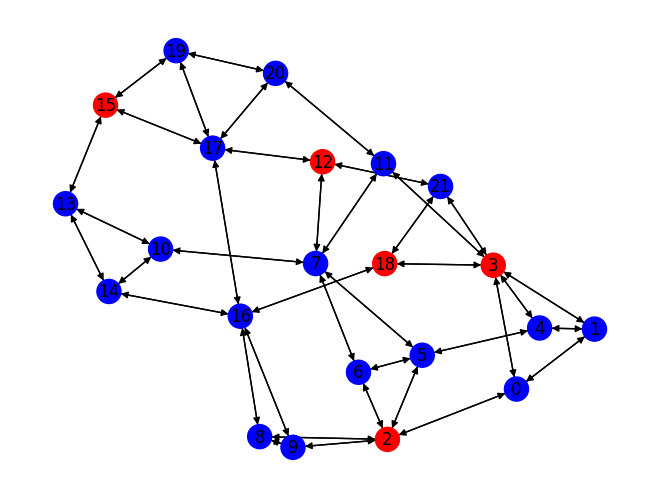

In [11]:
g = nx.DiGraph()
a = np.loadtxt("morenoedges.csv", delimiter=",",dtype=object)
a = a[1:].astype('int')
for edge in a:
    g.add_edge(edge[0],edge[1])
    
influentialnodes = [2,3,12,15,18]

# Create a dictionary that maps node numbers to colors
node_colors = {}
for node in g.nodes():
    if node in influentialnodes:
        node_colors[node] = 'red'
    else:
        node_colors[node] = 'blue'

# Draw the graph with colored nodes
pos = nx.spring_layout(g)  # Compute node positions using a spring layout
nx.draw(g, pos, with_labels=True, node_color=[node_colors[node] for node in g.nodes()])
plt.show()  # Di

1.2 Ranking top nodes with matrices

In [3]:
A = np.zeros(( len(g.nodes()), len(g.nodes()) ))

for nodeA, nodeB in combinations(list(g.nodes()), 2):
    A[nodeA][nodeB] = 1 if g.has_edge(nodeA, nodeB) else 0
    
I = np.eye(len(g.nodes()))

ones = np.ones((len(g.nodes()),1))

s = [1] * len(A)

In [4]:
def eigenvector_centrality(A : np.array) -> list:
    e = np.dot(s,A)
    return  e / np.sum(e)
def katz_centrality(A : np.array, a : float, b : float) -> list:
    k = a * np.dot(A, s) + b * ones
    return k / np.sum(k)
def pagerank_centrality(A : np.array, a : float, b : float) -> list:
    D = np.diag(np.sum(np.triu(A), axis=1))
    #Manually add noise to matrix: otherwise zero along diagonal makes determinant 0
    D[D.shape[0] - 1, D.shape[1] - 1] = 1
    D[D.shape[0] - 5, D.shape[1] - 5] = 1
    
    p = a * np.dot(A, np.dot(np.linalg.inv(D), s)) + b * ones
    return p / np.sum(p)

eigenvector centralities :


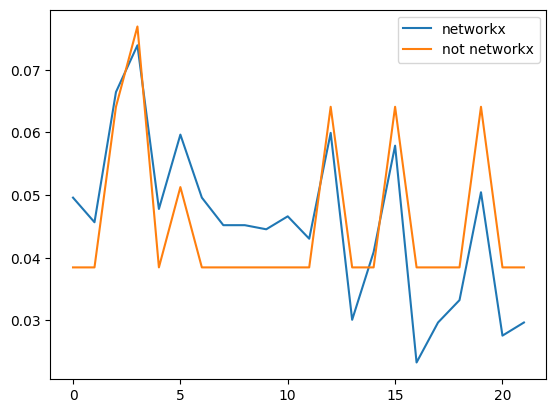

[0.03846154 0.03846154 0.06410256 0.07692308 0.03846154 0.05128205
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.06410256 0.03846154 0.03846154 0.06410256 0.03846154 0.03846154
 0.03846154 0.06410256 0.03846154 0.03846154]


pagerank centralities :


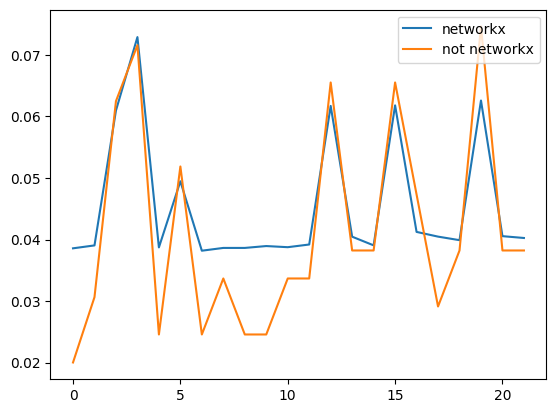

[0.001001   0.00153183 0.00312434 0.00357934 0.0012285  0.0025935
 0.0012285  0.0016835  0.0012285  0.0012285  0.0016835  0.0016835
 0.003276   0.001911   0.001911   0.003276   0.002366   0.001456
 0.001911   0.003731   0.001911   0.001911  ]


katz centralities :
[0.00175697 0.00175697 0.0028905  0.00345727 0.00175697 0.00232374
 0.00175697 0.00175697 0.00175697 0.00175697 0.00175697 0.00175697
 0.0028905  0.00175697 0.00175697 0.0028905  0.00175697 0.00175697
 0.00175697 0.0028905  0.00175697 0.00175697]


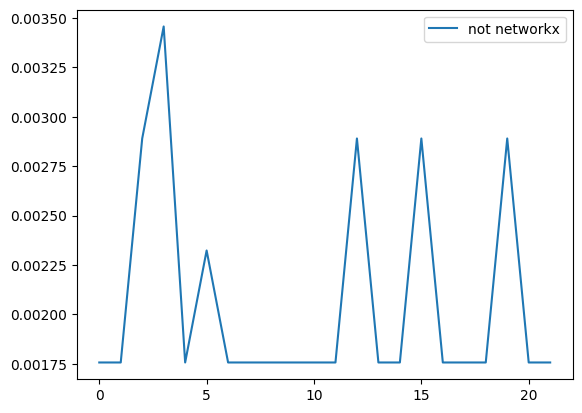

In [9]:
print('eigenvector centralities :')
plt.figure()
plt.plot(np.array(list(nx.eigenvector_centrality(g).values())) / np.sum(np.array(list(nx.eigenvector_centrality(g).values()))),label='networkx')
plt.plot(eigenvector_centrality(nx.adjacency_matrix(g).todense()),label='not networkx')
leg = plt.legend(loc='upper right')
plt.show()
print(eigenvector_centrality(nx.adjacency_matrix(g).todense()))
print('\n')

print('pagerank centralities :')
plt.figure()
plt.plot(np.array(list(nx.pagerank(g).values())),label='networkx')
plt.plot(20 * pagerank_centrality(nx.adjacency_matrix(g).todense(), 10, 1)[0],label='not networkx')
leg = plt.legend(loc='upper right')
plt.show()
print(pagerank_centrality(nx.adjacency_matrix(g).todense(), 10, 1)[0])
print('\n')

print('katz centralities :')
plt.figure()
plt.plot(katz_centrality(nx.adjacency_matrix(g).todense(), 10, 1)[0],label='not networkx')
#plt.plot(np.array(list(nx.katz_centrality_numpy(g, alpha=10, beta=1).values())) / np.sum(np.array(list(nx.katz_centrality_numpy(g, alpha=10, beta=1).values()))))
leg = plt.legend(loc='upper right')
print(katz_centrality(nx.adjacency_matrix(g).todense(), 10, 1)[0])
plt.show()

In [6]:
minimum = pagerank_centrality(nx.adjacency_matrix(g).todense(), .1, 1)[0]
middle = pagerank_centrality(nx.adjacency_matrix(g).todense(), .5, 1)[0]
high = pagerank_centrality(nx.adjacency_matrix(g).todense(), 100, 1)[0]

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


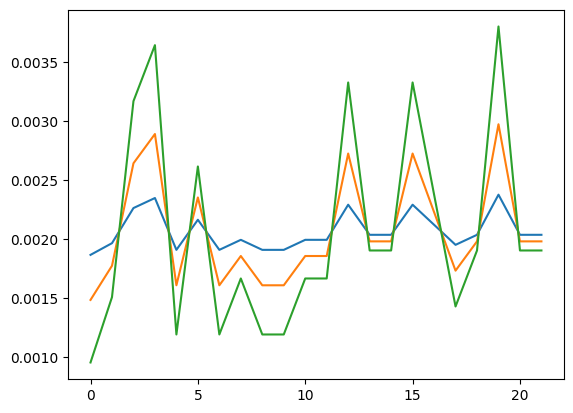

In [8]:
plt.plot(minimum)
plt.plot(middle)
plt.plot(high)
values = [minimum,middle,high]
print(np.corrcoef(values))

2 Modeling Evolution

In [ ]:
edges = pd.read_csv('phylogenetic_edges.txt')
nodes = pd.read_csv('phylogenetic_nodes.txt')
g = nx.DiGraph()
zipped = list(zip(nodes['ID'], nodes['epiweek'], nodes['region']))
for i in range(len(zipped)):
    nodeid = zipped[i][0]
    g.add_node(zipped[i][0], epiweek=zipped[i][1], region=zipped[i][2])
g.add_edges_from(edges.values)    

In [ ]:
nx.draw(g)

In [ ]:
def get_feature_vector(i, g):
    """Get feature vector of node i in graph g."""
    epiweek = g.nodes[i]['epiweek']
    if len(list(g.predecessors(i))) > 0:
        epiweek_pred = g.nodes[list(g.predecessors(i))[0]]['epiweek']
        return [np.log(g.out_degree(g)[i] + 1), (epiweek - epiweek_pred), g.nodes[i]['region']] 
    else :
        return [np.log(g.out_degree(g)[i] + 1),0, g.nodes[i]['region']] 

def get_features(g, C):
    """Get the feature vector of every node in the set of alternatives."""
    return [get_feature_vector(node, g) for node in C]
def get_probability(features, C, theta):
    """Calculate the probability of every possible choices, given the features, choice set and weight."""
    p = np.array([np.sum([np.exp(np.dot(float(features[node][feature]), theta)) for feature in range(len(get_feature_vector(1,g))) ]) for node in range(len(C))])
    p /= np.sum(p)
    return p

In [ ]:
def step(g, theta, epiweek):
    """Run one step of the simulation."""
    # get information needed to make choice
    C = list(range(g.number_of_nodes())) 
    #print(C)# we assume that the set of alternatives is all the nodes
    features = get_features(g, C)
    #print(features)
    p = get_probability(features, C, theta)
    # make choice
    new_node_id = g.number_of_nodes()  # the ID of the new incoming node
    chosen_node = np.random.choice(C, p=p)
    g.add_node(new_node_id, epiweek=epiweek, region=np.random.choice(1,1))# choose where this node will attach
    g.add_edge(chosen_node, new_node_id)
    # return data about the choice
    return {'chosen_node': chosen_node,
          'C': C,
          'features': features}


def simulate(theta, n=50):
    """Run a complete simulation generating a network of n nodes."""
    # initialize the graph
    g = nx.DiGraph()
    g.add_edge(0, 1)
    g.nodes[0]['epiweek'] = 0
    g.nodes[1]['epiweek'] = 1
    g.nodes[0]['region'] = 1
    g.nodes[1]['region'] = 1
    data = []
    epiweek = 1
    for i in range(n - 2):  # we start with 2 nodes so only make n - 2 choices
        data.append(step(g, theta, epiweek))
        epiweek += 1
    return g, data

def get_log_likelihood(data, theta):
    """Get the probability of the choice data."""
    log_likelihood = 0
    for choice_data in data:
        # get the probability vector for a specific value of theta
        p = get_probability(choice_data['features'], choice_data['C'], theta)
        # add the log-likelihood of the choice that was made to the total log-likelihood
        log_likelihood += np.log(p[choice_data['chosen_node']])
    return log_likelihood

In [ ]:
from scipy import optimize
import seaborn as sns
thetas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for theta in thetas:
    g, data = simulate(theta)
    results = optimize.minimize(lambda theta: -get_log_likelihood(data, theta), x0=1)
    theta_values = np.linspace(0, 2)
    plt.figure()
    plt.plot(theta_values, [get_log_likelihood(data, theta) for theta in theta_values])
    plt.axvline(results['x'], lw=1,  ls='--', c='k', label='MLE estimator')
    plt.axvline(theta, ls='-', c='#AAAAAA', lw=1, label='True parameter')
    plt.xlabel(r"$\theta$")
    plt.ylabel('Log-likelihood')
    sns.despine()
    plt.legend()
    plt.show()
    plt.figure()
    pos = nx.spring_layout(g, seed=1)
    nx.draw_networkx_nodes(g,pos,node_color=list(dict(nx.get_node_attributes(g,'epiweek')).values()))
    nx.draw(g)